In [152]:
import numpy as np
import matplotlib.pyplot as plt

In [153]:
from loaders import clean_text_for_pattern_letter
from temp_text import template_str
input_str = clean_text_for_pattern_letter(template_str, out_len=500)
print(len(input_str))
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
               'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '"', '\'', '1']
print(f'{letters=}')

len(letters)=32
500
letters=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '"', "'", '1']


In [154]:
def predict_train(input_str, letters, max_index: int = 4,):
    index_winner: dict[str, list] = {}
    index_by_prev: dict[str, dict] = {}

    StatsDict: dict[str, dict] = {}

    for letter in letters:
        index_winner[letter] = [0 for x in range(max_index)]
    # print(f'{index_winner=}')

    prev_index = 1

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_idx = inp_idx - 1
        prev_inp = input_str[prev_idx]

        by_prev_key = prev_inp + str(prev_index) + ':' + inp

        has_prev = index_by_prev.get(by_prev_key, -1)
        if has_prev != -1:
            inp_index = list(index_by_prev[by_prev_key].keys())[0]
        else:
            index_key = index_winner[inp].index(min(index_winner[inp]))
            inp_index = index_key + 1
            index_winner[inp][index_key] += 1
        # print(f'{inp_index=}')
        stats_key = prev_inp + str(prev_index) + ':' + inp + str(inp_index)
        StatsDict.setdefault(stats_key, {})

        next_inp = input_str[inp_idx + 1]
        StatsDict[stats_key].setdefault(next_inp, 0)

        StatsDict[stats_key][next_inp] += 1

        index_by_prev.setdefault(by_prev_key, {})
        index_by_prev[by_prev_key].setdefault(inp_index, 0)
        index_by_prev[by_prev_key][inp_index] += 1

        # recursion
        prev_index = inp_index
    
    print(f'{index_winner=}')
    for key, ibp in index_by_prev.items():
        print(f'{key} {ibp}')

    return StatsDict, index_by_prev


In [155]:
# max_index_L1 = 4

# index_by_prev_L1: dict[str, dict] = {}
# StatsDict_L1: dict[str, dict] = {}

# StatsDict, index_by_prev_L1 = predict_train(letters=letters, input_str=input_str, max_index=max_index_L1)

In [156]:
def predict(input_str, TF:list, StatsDict:dict, index_by_prev:dict, max_index, err = 0,):
    prev_index_l = [x for x in range(1, max_index+1)]

    output = []

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_inp = input_str[inp_idx - 1]
        
        index_l = []
        stats_d = {}
        index_d = {}
        for prev_index in prev_index_l:
            by_prev_key = prev_inp + str(prev_index) + ':' + inp
            print(by_prev_key)
            inp_index_arr = index_by_prev.get(by_prev_key, {-1: -1})
            print(inp_index_arr)

            for inp_index, val in inp_index_arr.items():
                if inp_index != -1:
                    index_d.setdefault(inp_index, 0)
                    index_d[inp_index] += val

                if inp_index != -1 and index_l.__contains__(inp_index) == False:
                    index_l.append(inp_index)

                    stats_key = prev_inp + str(prev_index) + ':' + inp + str(inp_index)
                    stats = StatsDict.get(stats_key, {})

                    next_inp = input_str[inp_idx + 1]
                    # print(next_inp, stats_key, stats)
                    for st_key, st in stats.items():
                        stats_d.setdefault(st_key, 0)
                        stats_d[st_key] += 1
        print(f'{index_d=}')
        # max_key_d = max(index_d, key=index_d.get)
        # if inp == prev_inp:
        #     pred_max_key = max_key_d
        #     max_key_d += 1
        #     if max_key_d > max_index:
        #         max_key_d = 1
            
        #     index_d[max_key_d] = index_d[pred_max_key]
        #     index_d.pop(pred_max_key)

        if len(stats_d) > 0:
            max_key = max(stats_d, key=stats_d.get)
            print(max_key, next_inp, stats_d, index_l, index_d, prev_index_l, inp == prev_inp)
            # B B {'B': 1} [3] {3: 1} [3] False
            output.append(max_key)

        prev_index_l = list(index_d.keys())
        
        if max_key != next_inp:
            err += 1

        stats_arr = np.array(list(stats_d.values()))
        predictability = np.sum(np.abs(stats_arr - stats_arr[np.newaxis].T))
        tf = predictability
        TF.append(tf)
    
    output.insert(0, input_str[1])
    
    return TF, err, output

In [157]:
# train
max_index_L1 = 4

index_by_prev_L1: dict[str, dict] = {}
StatsDict_L1: dict[str, dict] = {}

StatsDict, index_by_prev_L1 = predict_train(letters=letters, input_str=input_str, max_index=max_index_L1)

index_winner={'a': [6, 5, 5, 5], 'b': [1, 1, 1, 1], 'c': [2, 1, 1, 1], 'd': [4, 3, 3, 3], 'e': [8, 8, 8, 8], 'f': [2, 1, 1, 1], 'g': [2, 1, 1, 1], 'h': [3, 3, 3, 2], 'i': [5, 5, 5, 5], 'j': [1, 1, 0, 0], 'k': [2, 2, 2, 1], 'l': [3, 3, 3, 2], 'm': [2, 2, 1, 1], 'n': [4, 4, 4, 3], 'o': [8, 8, 7, 7], 'p': [2, 2, 2, 1], 'q': [0, 0, 0, 0], 'r': [4, 4, 3, 3], 's': [6, 5, 5, 5], 't': [4, 3, 3, 3], 'u': [2, 2, 2, 1], 'v': [2, 1, 1, 1], 'w': [2, 2, 1, 1], 'x': [1, 0, 0, 0], 'y': [2, 2, 2, 2], 'z': [1, 0, 0, 0], ' ': [12, 12, 11, 11], '.': [2, 1, 1, 1], ',': [1, 1, 1, 1], '"': [1, 1, 1, 1], "'": [1, 1, 1, 1], '1': [0, 0, 0, 0]}
t1:h {1: 6}
h1:e {1: 9}
e1:  {1: 10}
 1:s {1: 3}
s1:k {1: 1}
k1:y {1: 1}
y1:  {2: 1}
 2:a {1: 1}
a1:b {1: 1}
b1:o {1: 1}
o1:v {1: 1}
v1:e {2: 1}
e2:  {3: 2}
 3:t {1: 5}
 1:p {1: 1}
p1:o {2: 1}
o2:r {1: 3}
r1:t {2: 1}
t2:  {4: 2}
 4:w {1: 3}
w1:a {2: 4}
a2:s {2: 5}
s2:  {1: 6}
 1:t {3: 4}
t3:h {2: 2}
h2:e {3: 2}
e3:  {2: 4}
 2:c {1: 4}
c1:o {3: 2}
o3:l {1: 1}
l1:o {4: 1}
o

In [158]:
for sdk, sdv in index_by_prev_L1.items():
    print(sdk, sdv)
    print('')

t1:h {1: 6}

h1:e {1: 9}

e1:  {1: 10}

 1:s {1: 3}

s1:k {1: 1}

k1:y {1: 1}

y1:  {2: 1}

 2:a {1: 1}

a1:b {1: 1}

b1:o {1: 1}

o1:v {1: 1}

v1:e {2: 1}

e2:  {3: 2}

 3:t {1: 5}

 1:p {1: 1}

p1:o {2: 1}

o2:r {1: 3}

r1:t {2: 1}

t2:  {4: 2}

 4:w {1: 3}

w1:a {2: 4}

a2:s {2: 5}

s2:  {1: 6}

 1:t {3: 4}

t3:h {2: 2}

h2:e {3: 2}

e3:  {2: 4}

 2:c {1: 4}

c1:o {3: 2}

o3:l {1: 1}

l1:o {4: 1}

o4:r {2: 3}

r2:  {3: 3}

 3:o {1: 2}

o1:f {1: 3}

f1:  {4: 2}

 4:t {4: 3}

t4:e {4: 2}

e4:l {2: 2}

l2:e {1: 1}

e1:v {2: 2}

v2:i {1: 1}

i1:s {3: 1}

s3:i {2: 1}

i2:o {2: 2}

o2:n {1: 3}

n1:, {1: 1}

,1:  {1: 1}

t3:u {1: 1}

u1:n {2: 2}

n2:e {2: 2}

e2:d {1: 2}

d1:  {2: 3}

 2:t {1: 2}

t1:o {3: 1}

o3:  {3: 1}

 3:a {3: 3}

a3:  {4: 3}

 4:d {2: 1}

d2:e {3: 1}

e3:a {4: 2}

a4:d {3: 1}

d3:  {1: 2}

 1:c {2: 3}

c2:h {3: 2}

h3:a {1: 2}

a1:n {3: 1}

n3:n {4: 1}

n4:e {4: 1}

l2:. {1: 1}

.1:  {2: 2}

 2:" {1: 1}

"1:i {3: 1}

i3:t {2: 1}

t2:' {1: 1}

'1:s {4: 1}

s4:  {3: 3}

In [159]:
for sdk, sdv in StatsDict.items():
    print(sdk, sdv)
    print('')

t1:h1 {'e': 4, 'r': 1, 'i': 1}

h1:e1 {' ': 7, 'r': 1, 't': 1}

e1: 1 {'s': 3, 'p': 1, 'i': 1, 'c': 2, 'd': 1, 'a': 1, 'f': 1}

 1:s1 {'k': 1, 'a': 1, 'h': 1}

s1:k1 {'y': 1}

k1:y1 {' ': 1}

y1: 2 {'a': 1}

 2:a1 {'b': 1}

a1:b1 {'o': 1}

b1:o1 {'v': 1}

o1:v1 {'e': 1}

v1:e2 {' ': 1}

e2: 3 {'t': 1, 'h': 1}

 3:t1 {'h': 4, 'w': 1}

 1:p1 {'o': 1}

p1:o2 {'r': 1}

o2:r1 {'t': 1, ' ': 1, 'd': 1}

r1:t2 {' ': 1}

t2: 4 {'w': 2}

 4:w1 {'a': 2, 'e': 1}

w1:a2 {'s': 4}

a2:s2 {' ': 4, 'e': 1}

s2: 1 {'t': 2, 'd': 1, 'a': 2, 'i': 1}

 1:t3 {'h': 2, 'u': 1, 'e': 1}

t3:h2 {'e': 2}

h2:e3 {' ': 2}

e3: 2 {'c': 2, 'd': 1, 'f': 1}

 2:c1 {'o': 2, 'a': 1, 'h': 1}

c1:o3 {'l': 1, 'u': 1}

o3:l1 {'o': 1}

l1:o4 {'r': 1}

o4:r2 {' ': 3}

r2: 3 {'o': 2, 'a': 1}

 3:o1 {'f': 2}

o1:f1 {' ': 2, 'e': 1}

f1: 4 {'t': 2}

 4:t4 {'e': 1, 'h': 2}

t4:e4 {'l': 1, 's': 1}

e4:l2 {'e': 1, '.': 1}

l2:e1 {'v': 1}

e1:v2 {'i': 1, 'e': 1}

v2:i1 {'s': 1}

i1:s3 {'i': 1}

s3:i2 {'o': 1}

i2:o2 {'n': 2}

o2:n1 {'

In [160]:
# predict
TF = []

TF, err, out_L1 = predict(input_str=input_str, TF=TF, StatsDict=StatsDict, index_by_prev=index_by_prev_L1, max_index=max_index_L1)

print(err, err / (len(input_str) / 100) )

t1:h
{1: 6}
t2:h
{-1: -1}
t3:h
{2: 2}
t4:h
{1: 3}
index_d={1: 9, 2: 2}
e e {'e': 2, 'r': 1, 'i': 1} [1, 2] {1: 9, 2: 2} [1, 2, 3, 4] False
h1:e
{1: 9}
h2:e
{3: 2}
index_d={1: 9, 3: 2}
    {' ': 2, 'r': 1, 't': 1} [1, 3] {1: 9, 3: 2} [1, 2] False
e1: 
{1: 10}
e3: 
{2: 4}
index_d={1: 10, 2: 4}
c s {'s': 1, 'p': 1, 'i': 1, 'c': 2, 'd': 2, 'a': 1, 'f': 2} [1, 2] {1: 10, 2: 4} [1, 3] False
 1:s
{1: 3}
 2:s
{-1: -1}
index_d={1: 3}
k k {'k': 1, 'a': 1, 'h': 1} [1] {1: 3} [1, 2] False
s1:k
{1: 1}
index_d={1: 1}
y y {'y': 1} [1] {1: 1} [1] False
k1:y
{1: 1}
index_d={1: 1}
    {' ': 1} [1] {1: 1} [1] False
y1: 
{2: 1}
index_d={2: 1}
a a {'a': 1} [2] {2: 1} [1] False
 2:a
{1: 1}
index_d={1: 1}
b b {'b': 1} [1] {1: 1} [2] False
a1:b
{1: 1}
index_d={1: 1}
o o {'o': 1} [1] {1: 1} [1] False
b1:o
{1: 1}
index_d={1: 1}
v v {'v': 1} [1] {1: 1} [1] False
o1:v
{1: 1}
index_d={1: 1}
e e {'e': 1} [1] {1: 1} [1] False
v1:e
{2: 1}
index_d={2: 1}
    {' ': 1} [2] {2: 1} [1] False
e2: 
{3: 2}
index_d={3: 2}
t t

In [161]:
# def transition_freedom(input_str: str):
#     transition_freedom: dict[str, dict] = {}

#     for inp_idx, inp in enumerate(input_str):
#         if inp_idx <= 0:
#             continue

#         prev_idx = inp_idx - 1
#         prev_inp = input_str[prev_idx]

#         transition_freedom.setdefault(prev_inp, {})
#         transition_freedom[prev_inp].setdefault(inp, 0)

#     # print(transition_freedom)

#     for tf_key, tf in transition_freedom.items():
#         transition_freedom[tf_key] = len(tf)
    
#     # print(transition_freedom)

#     return transition_freedom
        
# TF_per_symbol = transition_freedom(input_str)
# TF = []
# for inp in input_str:
#     TF.append(TF_per_symbol[inp])
# print(len(TF), TF)

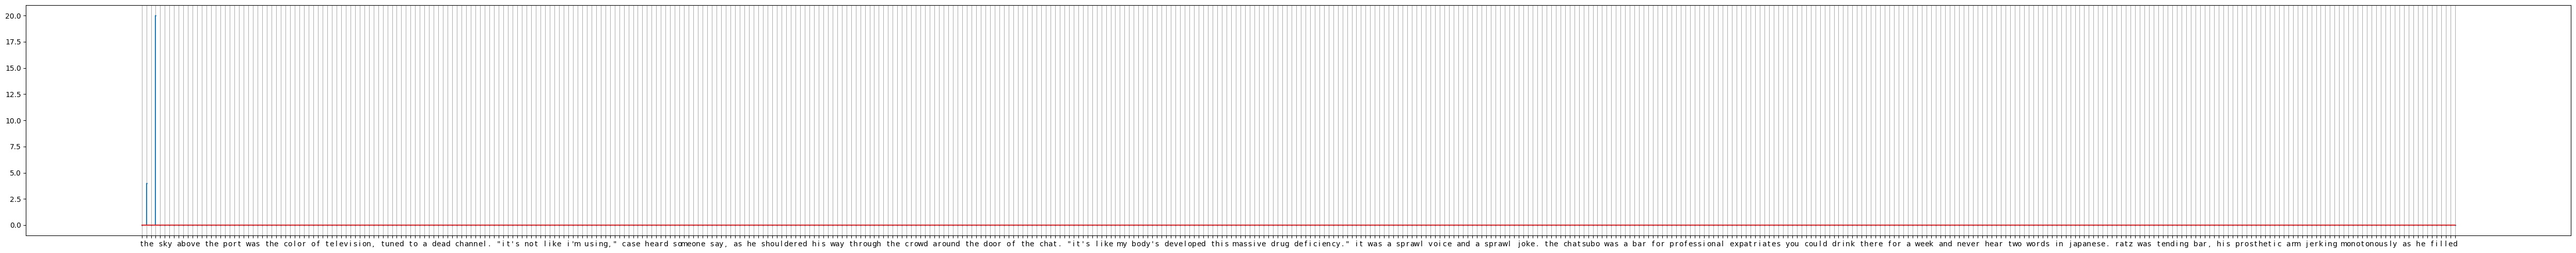

In [162]:
TF = np.array(TF, dtype=float)
# print(TF)
TF = np.pad(TF, (1, 1), constant_values=[0,0])
# # print(TF)
# TF = np.pad(TF, (1, 0))[:-1] - TF
# TF = TF - np.pad(TF, (1, 0))[:-1] 
# # TF = np.pad(TF, (1, 0))[:-1] - TF
# # TF = TF - np.pad(TF, (0, 1))[-1:]
# # print(TF)
# TF[np.where(TF < 0)] = 0

for idx in range(1):
    TF = TF - np.pad(TF, (1, 0))[:-1]
    TF[np.where(TF < 0)] = 0
    # TF[np.where(TF <= np.mean(TF[np.where(TF > 0)]))] = 0
# # TF = np.abs(TF)
# TF[np.where(TF <= np.mean(TF[np.where(TF > 0)]))] = 0
# # TF[np.where(TF <= 0.5)] = 0
# print(TF.size, TF.max(), TF.min())
# TF[np.where(TF <= np.mean(TF))] = 0

fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
# axs.plot(np.arange(TF.size), TF)
markerline, stemline, baseline, = axs.stem(np.arange(TF.size), TF)
plt.setp(markerline, markersize = 1)
axs.xaxis.set_ticks(np.arange(len(input_str)) ,input_str)
axs.xaxis.grid(True)

plt.show()

In [163]:
upstream_inp: dict[int, list] = {}

temp_seq = []

for inp_idx, inp in enumerate(input_str):
    tf = TF[inp_idx]
    
    if tf > 0:
        upstream_inp.setdefault(inp_idx, temp_seq.copy())
        temp_seq.clear()

    temp_seq.append(inp)

for item, val in upstream_inp.items():
    print(item, val)
    
print(len(upstream_inp))

1 ['t']
3 ['h', 'e']
2


In [164]:
letters_dict: dict[str, int] = {}
for let_idx, letter in enumerate(letters):
    letters_dict.setdefault(letter, let_idx)

upstream_patterns = []

for upstream_letters in upstream_inp.values():
    upstream_pattern = np.zeros(len(letters))

    for letter in upstream_letters:
        pattern_idx = letters_dict.get(letter, 0)

        upstream_pattern[pattern_idx] = 1
    
    upstream_patterns.append(upstream_pattern)

upstream_patterns = np.array(upstream_patterns)

for up_ptr in upstream_patterns:
    print(up_ptr.astype(int).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [165]:
layer_size = 32

I = np.zeros(upstream_patterns.shape[1])
O = np.zeros(layer_size)
W = np.ones((O.size, I.size))
Trace = np.zeros((O.size, I.size))
print('W', W.shape, W.max(), W.min(), np.median(W))

k = 1
push_delta = 0.4

prec = 1e-30

epoch_cnt = 100
eps0 = 0.02

eps = 0.05
rate_drop = 0.0

AVG_O = np.zeros(O.shape)
AVG_O_CNT = np.zeros(O.shape)

samples_idx = np.arange(upstream_patterns.shape[0])

for epoch_idx in range(epoch_cnt):
    np.random.shuffle(samples_idx)

    for i_idx in samples_idx:
        I = upstream_patterns[i_idx]

        # infer
        O = np.dot(W, I)

        # train
        winner_ids = np.argsort(O)[::-1][:1+k]
        winner = winner_ids[0]
        loosers = winner_ids[1:1+k]

        # update
        W[winner] = (1 - eps) * W[winner] + eps * (I - 0.5) + Trace[winner]*eps
        W[winner] = np.clip(W[winner], -1, 1)

        # W[loosers] = (1 - eps) * W[loosers] + (eps * (I - 0.5) * -push_delta) + Trace[loosers]*eps
        # W[loosers] = np.clip(W[loosers], -1, 1)

        # update Trace
        rate_Trace = np.zeros(I.shape)
        rate_Trace[(I > 0.5)] = 0.3
        rate_Trace[(I < 0.5)] = -0.001

        dTrace = np.zeros(W.shape)
        dTrace[winner] = rate_Trace
        Trace += dTrace
        Trace = np.clip(Trace, 0, 1)

        eps -= eps * rate_drop

print('W', W.shape, W.max(), W.min(), np.median(W))

W (32, 32) 1.0 1.0 1.0
W (32, 32) 1.0 -0.4586244643448374 0.8537499999999999


In [166]:
SL_symbols = [x.capitalize() for x in letters][:layer_size]
print(len(SL_symbols))

SLSymbolDict = {}

SL_symbols_d = {}
for idx, val in enumerate(SL_symbols):
    SL_symbols_d.setdefault(val + ':' + str(idx), 0)

upstream_inp_keys = list(upstream_inp.keys())

upstream_cluster_by_symbol: dict[str, int] = {}
for idx, val in enumerate(SL_symbols):
    upstream_cluster_by_symbol.setdefault(val, idx)

for upstr_idx, up_ptr in enumerate(upstream_patterns):
    O = np.dot(W, up_ptr)

    winner = np.argmax(O)
    symbol = SL_symbols[winner]
    print(SL_symbols[winner])

    # print(W[upstream_cluster_by_symbol[symbol]].tolist())

    sls = SL_symbols[winner]
    sls_key = upstream_inp_keys[upstr_idx]
    SLSymbolDict.setdefault(sls_key, sls)
    
    SL_symbols_d[SL_symbols[winner] + ':' + str(winner)] += 1

print(len(SL_symbols_d))
for key, val in SL_symbols_d.items():
    print(key, val)

print(SLSymbolDict)

32
P
1
32
A:0 0
B:1 0
C:2 0
D:3 0
E:4 0
F:5 0
G:6 0
H:7 0
I:8 0
J:9 0
K:10 0
L:11 0
M:12 0
N:13 0
O:14 0
P:15 1
Q:16 0
R:17 0
S:18 0
T:19 0
U:20 0
V:21 0
W:22 0
X:23 0
Y:24 0
Z:25 0
 :26 0
.:27 0
,:28 0
":29 0
':30 0
1:31 1
{1: 'P', 3: '1'}


In [167]:
sl_input = list(SLSymbolDict.values())
print(sl_input)

['P', '1']


In [168]:
# SL train
max_index_L2 = 8

StatsDict_L2, index_by_prev_L2 = predict_train(input_str=sl_input, letters=SL_symbols, max_index=max_index_L2)

index_winner={'A': [0, 0, 0, 0, 0, 0, 0, 0], 'B': [0, 0, 0, 0, 0, 0, 0, 0], 'C': [0, 0, 0, 0, 0, 0, 0, 0], 'D': [0, 0, 0, 0, 0, 0, 0, 0], 'E': [0, 0, 0, 0, 0, 0, 0, 0], 'F': [0, 0, 0, 0, 0, 0, 0, 0], 'G': [0, 0, 0, 0, 0, 0, 0, 0], 'H': [0, 0, 0, 0, 0, 0, 0, 0], 'I': [0, 0, 0, 0, 0, 0, 0, 0], 'J': [0, 0, 0, 0, 0, 0, 0, 0], 'K': [0, 0, 0, 0, 0, 0, 0, 0], 'L': [0, 0, 0, 0, 0, 0, 0, 0], 'M': [0, 0, 0, 0, 0, 0, 0, 0], 'N': [0, 0, 0, 0, 0, 0, 0, 0], 'O': [0, 0, 0, 0, 0, 0, 0, 0], 'P': [0, 0, 0, 0, 0, 0, 0, 0], 'Q': [0, 0, 0, 0, 0, 0, 0, 0], 'R': [0, 0, 0, 0, 0, 0, 0, 0], 'S': [0, 0, 0, 0, 0, 0, 0, 0], 'T': [0, 0, 0, 0, 0, 0, 0, 0], 'U': [0, 0, 0, 0, 0, 0, 0, 0], 'V': [0, 0, 0, 0, 0, 0, 0, 0], 'W': [0, 0, 0, 0, 0, 0, 0, 0], 'X': [0, 0, 0, 0, 0, 0, 0, 0], 'Y': [0, 0, 0, 0, 0, 0, 0, 0], 'Z': [0, 0, 0, 0, 0, 0, 0, 0], ' ': [0, 0, 0, 0, 0, 0, 0, 0], '.': [0, 0, 0, 0, 0, 0, 0, 0], ',': [0, 0, 0, 0, 0, 0, 0, 0], '"': [0, 0, 0, 0, 0, 0, 0, 0], "'": [0, 0, 0, 0, 0, 0, 0, 0], '1': [0, 0, 0, 0, 0, 0, 0

In [169]:
for sdk, sdv in StatsDict_L2.items():
    print(sdk, sdv)
    print('')

In [170]:
for sdk, sdv in index_by_prev_L2.items():
    print(sdk, sdv)
    print('')

In [171]:
# predict
TF_L2 = []

TF_L2, err_L2, out_L2 = predict(input_str=sl_input, 
                                TF=TF_L2, 
                                StatsDict=StatsDict_L2, 
                                index_by_prev=index_by_prev_L2, 
                                max_index=max_index_L2)

for o in out_L2:
    print(o)

print(err_L2, err_L2 / (len(sl_input) / 100), len(sl_input), len(out_L2) )

1
0 0.0 2 1


In [172]:
def ds_predict_train_without_index(input_str: str | list,
                                   #    sl_input: list,
                                   SLSymbolDict: dict,
                                   #    StatsDict_L1: dict,
                                   #    index_by_prev_L1: dict,
                                   #    max_index_L1: int,
                                   ):
    ds_symbol = '0'
    DsSymbolsStats = {}
    DsSymbolsStatsProb = {}

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        peak_symbol = SLSymbolDict.get(inp_idx, 0)  # inp_idx - 1
        if peak_symbol != 0:
            ds_symbol = peak_symbol

        DsSymbolsStats.setdefault(ds_symbol, {})
        DsSymbolsStats[ds_symbol].setdefault(inp, 0)

        DsSymbolsStats[ds_symbol][inp] += 1

    for ds_inp, inps in DsSymbolsStats.items():
        norm = sum(inps.values())

        for symbol, symbol_stats in inps.items():
            DsSymbolsStatsProb[ds_inp + ':' + symbol] = symbol_stats / norm

    return DsSymbolsStats, DsSymbolsStatsProb

In [173]:
DsSymbolsStats, DsSymbolsStatsProb = ds_predict_train_without_index(input_str, SLSymbolDict)
print(DsSymbolsStatsProb)

{'P:h': 0.5, 'P:e': 0.5, '1: ': 0.17943548387096775, '1:s': 0.0625, '1:k': 0.014112903225806451, '1:y': 0.016129032258064516, '1:a': 0.07258064516129033, '1:b': 0.010080645161290322, '1:o': 0.07056451612903226, '1:v': 0.012096774193548387, '1:e': 0.09274193548387097, '1:t': 0.05443548387096774, '1:h': 0.04233870967741935, '1:p': 0.016129032258064516, '1:r': 0.05241935483870968, '1:w': 0.02217741935483871, '1:c': 0.02217741935483871, '1:l': 0.028225806451612902, '1:f': 0.014112903225806451, '1:i': 0.04838709677419355, '1:n': 0.04233870967741935, '1:,': 0.008064516129032258, '1:u': 0.020161290322580645, '1:d': 0.04032258064516129, '1:.': 0.010080645161290322, '1:"': 0.008064516129032258, "1:'": 0.008064516129032258, '1:m': 0.012096774193548387, '1:g': 0.010080645161290322, '1:j': 0.006048387096774193, '1:x': 0.0020161290322580645, '1:z': 0.0020161290322580645}


In [174]:
# from itertools import cycle

def ds_predict(input_str, 
               StatsDict: dict, 
               index_by_prev: dict,
               upstream_cluster_by_symbol: dict,
               letters_dict: dict,
               out_L2: list,
               SLSymbolDict: dict,
               W,
               DsSymbolsStats: dict,
               max_index):
    prev_index_l = [x for x in range(1, max_index+1)]

    err = 0
    TF = []
    output = []

    ds_out_idx = 0
    ds_inp = '0'
    # ds_pattern = np.ones(W.shape[1])

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_inp = input_str[inp_idx - 1]
        
        index_l = []
        stats_d = {}
        index_d = {}
        for prev_index in prev_index_l:
            by_prev_key = prev_inp + str(prev_index) + ':' + inp
            # print(by_prev_key)
            inp_index_arr = index_by_prev.get(by_prev_key, {-1: -1})
            # print(inp_index_arr)

            for inp_index, val in inp_index_arr.items():
                if inp_index != -1:
                    index_d.setdefault(inp_index, 0)
                    index_d[inp_index] += val

                if inp_index != -1 and index_l.__contains__(inp_index) == False:
                    index_l.append(inp_index)

                    stats_key = prev_inp + str(prev_index) + ':' + inp + str(inp_index)
                    stats = StatsDict.get(stats_key, {})

                    next_inp = input_str[inp_idx + 1]
                    # print(next_inp, stats_key, stats)
                    for st_key, st in stats.items():
                        stats_d.setdefault(st_key, 0)
                        stats_d[st_key] += 1

        # downstream
        is_peak = SLSymbolDict.get(inp_idx, 0)
        if is_peak != 0:
            if ds_out_idx == len(out_L2):
                ds_inp = '0'
                # ds_pattern = np.ones(W.shape[1])
            else:
                ds_inp = out_L2[ds_out_idx]
                # ds_pattern = W[upstream_cluster_by_symbol.get(ds_inp)]
                # ds_pattern = np.copy(W[upstream_cluster_by_symbol.get(ds_inp)])
                # ds_pattern[np.where(ds_pattern < 0)] = 0

                ds_out_idx += 1
        print(stats_d)

        # prob stats
        # norm = sum(stats_d.values())
        # for st_key, st in stats_d.items():
        #     stats_d[st_key] = st / norm

        for st_key, st in stats_d.items():
            # letter_idx = letters_dict.get(st_key)
            
            # ds_stats = ds_pattern[letter_idx]
            ds_key = ds_inp + ':' + st_key
            ds_stats = DsSymbolsStats.get(ds_key, 0)
            print('st_ds:', st_key, st, ds_key, ds_stats)
            if ds_stats <= 0:
                stats_d[st_key] = 0

                continue
            
            stats_d[st_key] *= ds_stats
            print('upd:', ds_stats)
        
        print(stats_d)
        print(input_str[inp_idx + 1], max(stats_d, key=stats_d.get))
        print()

        max_key_d = max(index_d, key=index_d.get)
        if inp == prev_inp:
            pred_max_key = max_key_d
            max_key_d += 1
            if max_key_d > max_index:
                max_key_d = 1
            
            index_d[max_key_d] = index_d[pred_max_key]
            index_d.pop(pred_max_key)

        if len(stats_d) > 0:
            max_key = max(stats_d, key=stats_d.get)
            # print(max_key, next_inp, stats_d, index_l, index_d, prev_index_l, inp == prev_inp)
            output.append(max_key)

        prev_index_l = list(index_d.keys())
        
        if max_key != next_inp:
            err += 1

        tf = len(index_l)
        TF.append(tf)
    
    output.insert(0, input_str[1])
    
    return TF, err, output

In [175]:
DsSymbolsStats, DsSymbolsStatsProb = ds_predict_train_without_index(input_str, SLSymbolDict)

dsp_TF, dsp_err, dsp_output = ds_predict(input_str=input_str,
                                         StatsDict=StatsDict,
                                         index_by_prev=index_by_prev_L1,
                                         upstream_cluster_by_symbol=upstream_cluster_by_symbol,
                                         letters_dict=letters_dict,
                                         out_L2=out_L2,
                                         SLSymbolDict=SLSymbolDict,
                                         W=W,
                                         DsSymbolsStats=DsSymbolsStatsProb,
                                         max_index=max_index_L1)

print(dsp_err, dsp_err / (len(input_str) / 100))


{'e': 2, 'r': 1, 'i': 1}
st_ds: e 2 1:e 0.09274193548387097
upd: 0.09274193548387097
st_ds: r 1 1:r 0.05241935483870968
upd: 0.05241935483870968
st_ds: i 1 1:i 0.04838709677419355
upd: 0.04838709677419355
{'e': 0.18548387096774194, 'r': 0.05241935483870968, 'i': 0.04838709677419355}
e e

{' ': 2, 'r': 1, 't': 1}
st_ds:   2 1:  0.17943548387096775
upd: 0.17943548387096775
st_ds: r 1 1:r 0.05241935483870968
upd: 0.05241935483870968
st_ds: t 1 1:t 0.05443548387096774
upd: 0.05443548387096774
{' ': 0.3588709677419355, 'r': 0.05241935483870968, 't': 0.05443548387096774}
   

{'s': 1, 'p': 1, 'i': 1, 'c': 2, 'd': 2, 'a': 1, 'f': 2}
st_ds: s 1 0:s 0
st_ds: p 1 0:p 0
st_ds: i 1 0:i 0
st_ds: c 2 0:c 0
st_ds: d 2 0:d 0
st_ds: a 1 0:a 0
st_ds: f 2 0:f 0
{'s': 0, 'p': 0, 'i': 0, 'c': 0, 'd': 0, 'a': 0, 'f': 0}
s s

{'k': 1, 'a': 1, 'h': 1}
st_ds: k 1 0:k 0
st_ds: a 1 0:a 0
st_ds: h 1 0:h 0
{'k': 0, 'a': 0, 'h': 0}
k k

{'y': 1}
st_ds: y 1 0:y 0
{'y': 0}
y y

{' ': 1}
st_ds:   1 0:  0
{' ': 0}
   


ValueError: max() arg is an empty sequence

In [ ]:
ds_predict_train_without_index(input_str, SLSymbolDict)

({'0': {'h': 1},
  'U': {'e': 7,
   ' ': 12,
   's': 5,
   'k': 1,
   'y': 1,
   'a': 5,
   'b': 2,
   'o': 6,
   'v': 1,
   'f': 3,
   'r': 2,
   'd': 2,
   'h': 2,
   't': 3,
   'c': 1,
   'u': 2,
   'w': 1,
   'l': 3,
   'i': 1},
  'Q': {' ': 13,
   't': 1,
   'i': 4,
   "'": 1,
   'm': 1,
   'u': 3,
   's': 5,
   'n': 1,
   'g': 2,
   ',': 2,
   '"': 1,
   'c': 1,
   'a': 4,
   'h': 2,
   'y': 2,
   'l': 1,
   'd': 4,
   'e': 4,
   'r': 2,
   'w': 1,
   'v': 1},
  'H': {'h': 7,
   'd': 2,
   'e': 2,
   'r': 2,
   'o': 2,
   'u': 2,
   'g': 1,
   ' ': 4,
   'c': 1,
   'w': 1,
   'i': 1,
   's': 2,
   'm': 1,
   'a': 1,
   'l': 1,
   'y': 1},
  'J': {'e': 7,
   ' ': 11,
   'p': 1,
   'o': 6,
   'r': 4,
   't': 5,
   'w': 1,
   'a': 3,
   'c': 2,
   'h': 1,
   '.': 1,
   '"': 1,
   'i': 4,
   "'": 2,
   's': 2,
   'l': 1,
   'k': 2,
   'm': 3,
   'y': 2,
   'b': 1,
   'd': 1,
   'j': 1,
   'n': 3,
   'g': 1},
  'D': {'s': 4,
   't': 4,
   'h': 2,
   'e': 4,
   ' ': 6,
   'c': 1,
   'o

In [ ]:
def downstream_predict_train(input_str: str | list,
                             sl_input: list,
                             SLSymbolDict: dict,
                            #  ds_out: list,
                             StatsDict_L1: dict,
                            #  StatsDict_L2,
                            #  TF_L1,
                             index_by_prev_L1: dict,
                            #  index_by_prev_L2,
                             max_index_L1: int,
                            #  max_index_L2,
                             ):
    next_index: dict[str, int] = {}

    for letter in letters:
        next_index[letter] = 1

    ds_inp = '0'
    sl_inp_idx = 1

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_idx = inp_idx - 1
        prev_inp = input_str[prev_idx]

        inp_index = next_index[inp]

        prev_index = next_index[prev_inp]

        is_peak = SLSymbolDict.get(inp_idx, 0)
        if is_peak != 0:
            if sl_inp_idx == len(sl_input):
                ds_inp = '0'
            else:
                ds_inp = sl_input[sl_inp_idx]
                sl_inp_idx += 1
        # print(f'{ds_inp=}')
        stats_key = ds_inp + ':' + prev_inp + str(prev_index) + ':' + inp + str(inp_index)
        StatsDict_L1.setdefault(stats_key, {})

        next_inp = input_str[inp_idx + 1]
        StatsDict_L1[stats_key].setdefault(next_inp, 0)

        StatsDict_L1[stats_key][next_inp] += 1

        by_prev_key = ds_inp + ':' + prev_inp + str(prev_index) + ':' + inp
        index_by_prev_L1.setdefault(by_prev_key, {})
        index_by_prev_L1[by_prev_key].setdefault(inp_index, 0)
        index_by_prev_L1[by_prev_key][inp_index] += 1

        by_prev_key = ds_inp + ':' + prev_inp + str(0) + ':' + inp
        index_by_prev_L1.setdefault(by_prev_key, {})
        index_by_prev_L1[by_prev_key].setdefault(inp_index, 0)
        index_by_prev_L1[by_prev_key][inp_index] += 1

        next_index[prev_inp] += 1
        if next_index[prev_inp] > max_index_L1:
            next_index[prev_inp] = 1
        
    return StatsDict_L1, index_by_prev_L1


In [ ]:
StatsDict_L1_ds = {}
index_by_prev_L1_ds = {}

StatsDict_L1_ds, index_by_prev_L1_ds = downstream_predict_train(input_str=input_str,
                                                                sl_input=sl_input,
                                                                SLSymbolDict=SLSymbolDict,
                                                                StatsDict_L1=StatsDict_L1_ds,
                                                                index_by_prev_L1=index_by_prev_L1_ds,
                                                                max_index_L1=max_index_L1, )

for key, val in StatsDict_L1_ds.items():
    print(key, val)

0:t1:h1 {'e': 1}
Q:h1:e1 {' ': 1}
Q:e1: 1 {'s': 1}
Q: 1:s1 {'k': 1}
Q:s1:k1 {'y': 1}
Q:k1:y1 {' ': 1}
Q:y1: 2 {'a': 1}
Q: 2:a1 {'b': 1}
Q:a1:b1 {'o': 1}
Q:b1:o1 {'v': 1}
Q:o1:v1 {'e': 1}
Q:v1:e2 {' ': 1}
H:e2: 3 {'t': 1}
H: 3:t2 {'h': 2}
J:t2:h2 {'e': 2}
D:h2:e3 {' ': 1}
D:e3: 4 {'p': 1, 'f': 1}
D: 4:p1 {'o': 1}
D:p1:o2 {'r': 1}
D:o2:r1 {'t': 1}
D:r1:t3 {' ': 1}
D:t3: 1 {'w': 1}
D: 1:w1 {'a': 1}
D:w1:a2 {'s': 1}
E:a2:s2 {' ': 1}
D:s2: 2 {'t': 1}
U: 2:t4 {'h': 1}
U:t4:h3 {'e': 1}
U:h3:e4 {' ': 1}
U:e4: 3 {'c': 1}
U: 3:c1 {'o': 1}
U:c1:o3 {'l': 1}
U:o3:l1 {'o': 1}
U:l1:o4 {'r': 1}
U:o4:r2 {' ': 1}
,:r2: 4 {'o': 1}
,: 4:o1 {'f': 1}
,:o1:f1 {' ': 1}
,:f1: 1 {'t': 1}
T: 1:t1 {'e': 1}
T:t1:e1 {'l': 1}
T:e1:l2 {'e': 1}
T:l2:e2 {'v': 1}
S:e2:v2 {'i': 1}
S:v2:i1 {'s': 1}
S:i1:s3 {'i': 1}
,:s3:i2 {'o': 1}
,:i2:o2 {'n': 1}
,:o2:n1 {',': 1}
,:n1:,1 {' ': 1}
,:,1: 2 {'t': 1}
B: 2:t2 {'u': 1}
B:t2:u1 {'n': 1}
B:u1:n2 {'e': 1}
B:n2:e3 {'d': 1}
B:e3:d1 {' ': 1}
B:d1: 3 {'t': 1}
H: 3:t3 {'o': 1}
H:t3:o

In [ ]:
from itertools import cycle

print(out_L2)
def downstream_predict(input_str: str | list,
                       SLSymbolDict: dict,
                       StatsDict_L1_ds: dict,
                       index_by_prev_L1_ds: dict,
                       out_L2: list,
                       max_index_L1: int,
                       TF: list,
                       err=0,):
    prev_index_l = [x for x in range(1, max_index_L1+1)]

    ds_inp = '0'
    ds_out_idx = 0
    ds_predict_out = cycle(out_L2)

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_inp = input_str[inp_idx - 1]

        # print(inp, SLSymbolDict.get(inp_idx, 0))
        is_peak = SLSymbolDict.get(inp_idx, 0)
        if is_peak != 0:
            if ds_out_idx == len(out_L2):
                ds_inp = '0'
            else:
                ds_inp = out_L2[ds_out_idx]
                ds_out_idx += 1
        print(ds_inp, is_peak)
        index_l = []
        stats_d = {}
        index_d = {}
        for prev_index in prev_index_l:
            by_prev_key = ds_inp + ':' + prev_inp + str(prev_index) + ':' + inp
            # print(by_prev_key)
            inp_index_arr = index_by_prev_L1_ds.get(by_prev_key, {-1: -1})
            # print(inp_index_arr)

            for inp_index, val in inp_index_arr.items():
                if inp_index != -1:
                    index_d.setdefault(inp_index, 0)
                    index_d[inp_index] += val

                if inp_index != -1 and index_l.__contains__(inp_index) == False:
                    index_l.append(inp_index)

                    stats_key = ds_inp + ':' + prev_inp + \
                        str(prev_index) + ':' + inp + str(inp_index)
                    stats = StatsDict_L1_ds.get(stats_key, {})

                    next_inp = input_str[inp_idx + 1]
                    # print(next_inp, stats_key, stats)
                    for st_key, st in stats.items():
                        stats_d.setdefault(st_key, 0)
                        stats_d[st_key] += 1

        max_key_d = max(index_d, key=index_d.get)
        if inp == prev_inp:
            pred_max_key = max_key_d
            max_key_d += 1
            if max_key_d > max_index_L1:
                max_key_d = 1

            index_d[max_key_d] = index_d[pred_max_key]
            index_d.pop(pred_max_key)

        if len(stats_d) > 0:
            max_key = max(stats_d, key=stats_d.get)
            # print(max_key, next_inp, stats_d, index_l, index_d, prev_index_l, inp == prev_inp)

        prev_index_l = list(index_d.keys())

        if max_key != next_inp:
            err += 1

        tf = len(index_l)
        TF.append(tf)

    return TF, err


['Q', 'H', 'J', 'D', 'E', 'D', 'U', ',', 'T', 'S', ',', 'B', 'H', 'X', 'C', 'Y', 'Q', 'O', 'Q', 'U', 'N', 'D', 'Q', 'E', 'E', 'U', 'Q', 'K', 'H', 'U', 'H', 'Y', 'D', 'N', 'A', 'B', 'D', 'U', ',', 'H', 'J', 'Q', ' ', 'Y', 'D', 'H', 'Q', 'S', ' ', 'E', 'D', 'E', '"', 'Y', 'E', 'I', 'E', '"', 'Y', 'U', 'U', 'E', 'U', 'K', 'I', 'H', 'J', 'D', 'A', 'D', 'E', 'D', 'Y', 'D', 'Z', '.', 'D', 'E', 'U', 'Z', 'J', 'H', 'K', 'E', 'U']


In [ ]:
TF_L1_ds = []

TF_L1_ds, err_L1_ds = downstream_predict(input_str=input_str,
                                         SLSymbolDict=SLSymbolDict,
                                         StatsDict_L1_ds=StatsDict_L1_ds,
                                         index_by_prev_L1_ds=index_by_prev_L1_ds,
                                         out_L2=out_L2,
                                         max_index_L1=max_index_L1,
                                         TF=TF_L1_ds, )

print(err_L1_ds, err_L1_ds / (len(input_str) / 100))

0 0
Q U
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
H Q
H 0
J H
D J
D 0
D 0
D 0
D 0
D 0
D 0
D 0
D 0
E D
D E
U D
U 0
U 0
U 0
U 0
U 0
U 0
U 0
U 0
, U
, 0
, 0
, 0
T ,
T 0
T 0
T 0
S T
S 0
S 0
, S
, 0
, 0
, 0
, 0
B ,
B 0
B 0
B 0
B 0
B 0
H B
H 0
H 0
H 0
H 0
X H
X 0
C X
C 0
Y C
Y 0
Y 0
Y 0
Q Y
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
O Q
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
Q O
Q 0
U Q
U 0
N U
N 0
N 0
N 0
D N
Q D
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
E Q
E 0
E 0
E 0
E 0
E 0
E 0
E E
U E
U 0
Q U
Q 0
Q 0
Q 0
Q 0
K Q
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
H K
U H
U 0
U 0
U 0
U 0
U 0
U 0
H U
Y H
Y 0
Y 0
Y 0
Y 0
Y 0
Y 0
Y 0
D Y
N D
N 0
A N
B A
B 0
B 0
D B
U D
U 0
U 0
U 0
U 0
U 0
U 0
U 0
, U
, 0
, 0
, 0
H ,
J H
Q J
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
  Q
  0
  0
Y  
Y 0
Y 0
Y 0
Y 0
Y 0
Y 0
D Y
H D
Q H
Q 0
Q 0
Q 0
Q 0
Q 0
S Q
S 0
S 0
S 0
S 0
S 0
S 0
S 0
S 0
S 0
S 0
  S
  0


ValueError: max() arg is an empty sequence